# Первым этапом для выполнения задания будет являться импорт необходимых питон-библиотек;

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
import numpy as np
import scipy.stats as stats
%matplotlib inline

# Далее необходимо выгрузить нужные по заданию данные из кликхауса;

In [108]:
connection_0 = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
}

query = """
SELECT exp_group, user_id, SUM(action = 'like') AS likes, SUM(action = 'view') AS views, likes/ views AS CTR
FROM {db}.feed_actions
WHERE (toDate(time) BETWEEN '2022-12-02' AND '2022-12-08' ) AND exp_group IN (1, 2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(query, connection = connection_0)
df

,exp_group,user_id,likes,views,CTR
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


# Можно сгруппировать данные по экспериментальной группе и проверить количество наблюдей в каждой их них;

In [109]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

# Количество наблюдений в группах примерно одинаковое, можно строить гистограмму распределения значения CTR по группам;

<AxesSubplot:xlabel='CTR', ylabel='Count'>

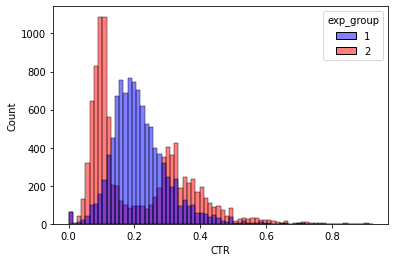

In [110]:
sns.histplot(data = df, x = 'CTR', hue = 'exp_group', palette = ['b', 'r'])

# Также проверим внутригрупповое средние значения по CTR;

In [111]:
print(df[df.exp_group == 1].CTR.mean())
print(df[df.exp_group == 2].CTR.mean())

0.21560459841296287
0.21441927347479375


# По гистограмме визуально можно судить, что контрольная группа распределена примерно нормально, однако экспериментальная группа имеет скошенное распределение, соотвестственно данные распределены в ней ненормально. При этом средние значения по группам имеют примерно одинаковые значения, необходимо провести соответствующие тесты. Можно провести Т-тест;

In [112]:
a, b = df[df.exp_group == 1].CTR, df[df.exp_group == 2].CTR
stats.ttest_ind(a, b, equal_var = False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

# По результатам Т-теста Р-уровень значимости ~ 0.5, это значит, мы не можем отклонить гипотезу о равенстве средних между группами. Далее проведем тест Манна-Уитни, нулевая гипотеза звучит примерно так: верояность того, что случайное значение из контрольной выборки больше случайного значения из эксперименртальной, равна вероятности того, что случайное значение из экспериментальной больше случайного значения из контрольной выборки;

In [113]:
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

# По результатам теста Манна-Уитни, мы можем отклонить гипотезу о равенстве вероятностей. Так как оба тесты показали разные результаты, далее проведем Т-тест на сглаженном CTR;

<AxesSubplot:xlabel='CTR', ylabel='Count'>

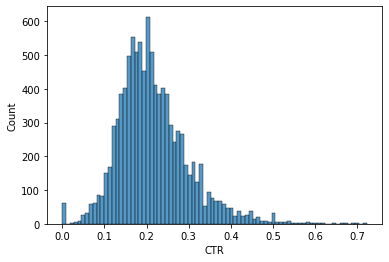

In [114]:
# Для сглаживания CTR мы используем функцию из лекции
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.CTR, 
             kde = False)

<AxesSubplot:xlabel='smothed_CTR', ylabel='Count'>

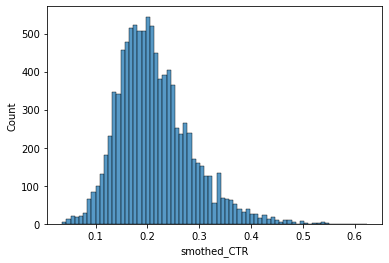

In [115]:
group1['smothed_CTR'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_CTR, 
             kde = False)

<AxesSubplot:xlabel='CTR', ylabel='Count'>

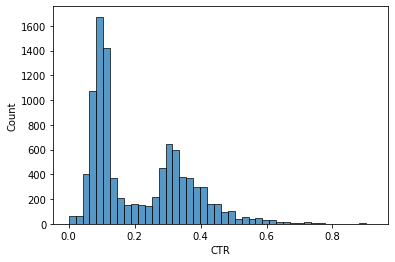

In [116]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.CTR, 
             kde = False)

<AxesSubplot:xlabel='smothed_CTR', ylabel='Count'>

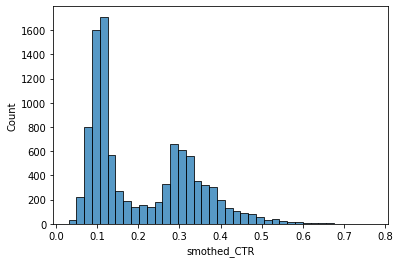

In [117]:
group2['smothed_CTR'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_CTR, 
             kde = False)

In [118]:
c, d = group1.smothed_CTR, group2.smothed_CTR
stats.ttest_ind(c, d, equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

# По итогам Т-теста по сглаженному CTR, мы можем отклонить гипотезу о равенстве средних, таким образом, если заменить данные пользователей, имеющих низкую активность в обеих группах, то можно получить статистически значимые отличия между группами. Далее проведем Пуассоновский бутстреп и сравним полученные значения CTR;

In [119]:
# Для распределения Пуассона по нашим данным используем функцию из лекции
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

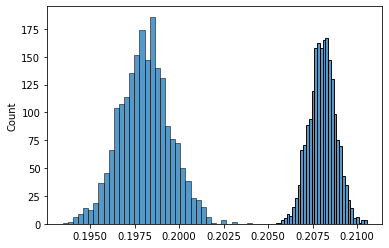

In [120]:

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

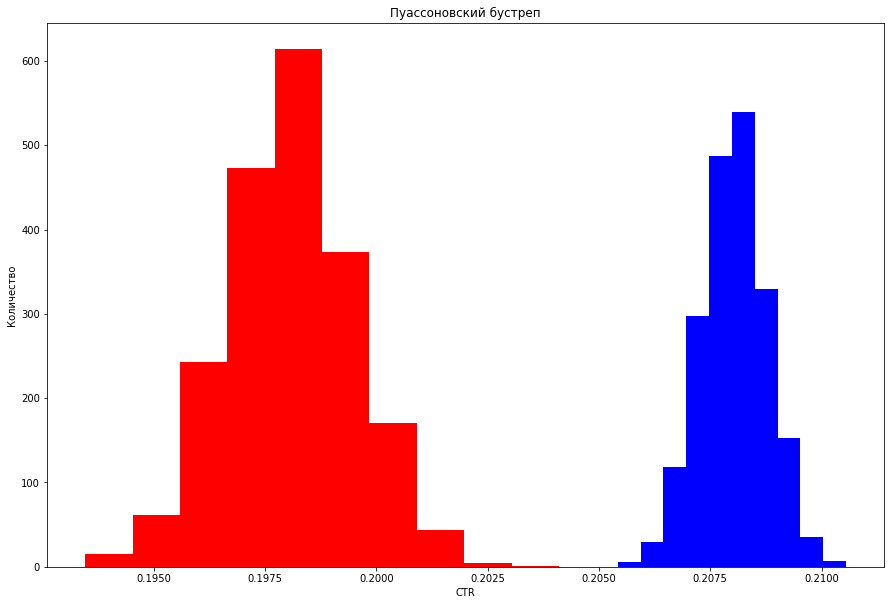

In [121]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10))

ax.hist(ctr1, density = False, facecolor = 'b')
ax.hist(ctr2, density = False, facecolor = 'r')

plt.xlabel('CTR') 
plt.ylabel('Количество') 
plt.title('Пуассоновский бустреп')

plt.show()

<AxesSubplot:ylabel='Count'>

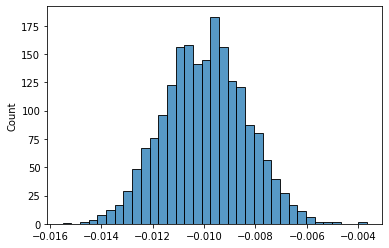

In [122]:
sns.histplot(ctr2 - ctr1)

# Таким образом, после Пуассоновского преобразования распределения значений CTR, мы наглядно видим разницу CTR между группами, а именно то, что CTR в контрольной группе оказался больше, чем в экспериментальной. В заключение, проведем Т-тест и тест Манна-Уитни поверх бакетного преобразования;

In [123]:
# Используем запрос из лекции
q = """

SELECT exp_group, bucket, SUM(likes)/SUM(views) AS bucket_CTR, quantileExact(0.9)(ctr) AS CTR_9
FROM (
SELECT exp_group, xxHash64(user_id)%50 AS bucket, user_id, SUM(action = 'like') AS likes, SUM(action = 'view') AS views, likes/views AS ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-02' AND '2022-12-08' AND exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_bucket = pandahouse.read_clickhouse(q, connection=connection)

In [124]:
e, f = df_bucket[df_bucket.exp_group == 1].bucket_CTR, df_bucket[df_bucket.exp_group == 2].bucket_CTR
stats.mannwhitneyu(e, f, alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [125]:
stats.ttest_ind(e, f, equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

# Для выбранных нами бакетов (условных метапользователей) мы получили Р-уровни значимости по тестам, позволяющие отклонить гипотезы о равенстве средних и вероятностях случайных величин. Также мы еще считали 90%-квантиль по CTR-у. Построим графики распределения CTR и CTR для 90% квантиля по обеим группам;

<AxesSubplot:xlabel='bucket_CTR', ylabel='Count'>

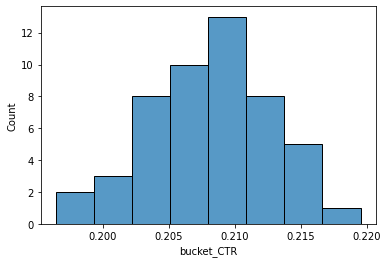

In [126]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].bucket_CTR)

<AxesSubplot:xlabel='bucket_CTR', ylabel='Count'>

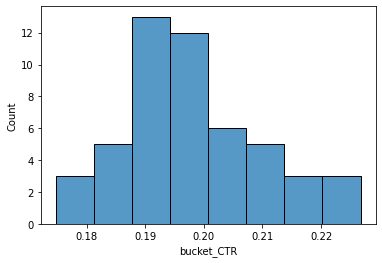

In [127]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].bucket_CTR)

# По общему CTR контрольная группа распределена нормально, но экспериментально визуально имеет две моды;

<AxesSubplot:xlabel='CTR_9', ylabel='Count'>

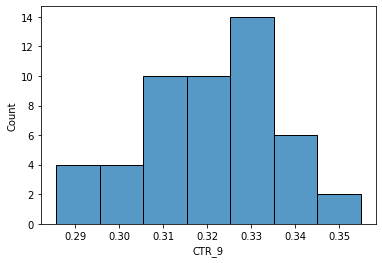

In [128]:
sns.histplot(df_bucket[df_bucket.exp_group == 1].CTR_9)

<AxesSubplot:xlabel='CTR_9', ylabel='Count'>

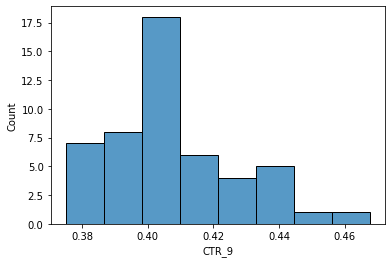

In [129]:
sns.histplot(df_bucket[df_bucket.exp_group == 2].CTR_9)

# По 90% квантилю обе группы имеют перекос, хотя оба графика похожи на нормальное распределение, можно провести оба теста;

In [130]:
g, h = df_bucket[df_bucket.exp_group == 1].CTR_9, df_bucket[df_bucket.exp_group == 2].CTR_9
stats.mannwhitneyu(g, h, alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

In [131]:
stats.ttest_ind(g, h, equal_var = False)

Ttest_indResult(statistic=-23.214341215937406, pvalue=1.2945537024964474e-40)

# По полученным результатам тестов и методов можно сделать следующие выводы. Изначально контрольная группа и экспериментальная имели разное распределение - нормальное и ненормальное. Соответственно, это сказалось на полученных результатах Т-теста, но после сглаживания CTR получилось изменить результаты Т-теста на статистически значимые. При этом, результаты теста Манна-Уитни всегда позволяли отклонить гипотезу о равеностве вероятностей случайных значений из выборок. Пуассоновское распределение значений CTR по группам позволило наглядно оценить разность значений между группами, значения CTR в контрольной группе оказались больше, чем в экспериментальной и это распределение визуально имеет нормальный вид, однако же этот метод не рекондуется применять в данном эксперименте, так как на начальных данных экспериментльная группа имела бимодальное распределение, а после преобразования оно столо унимодальным. Бакетное преобразование позволило привести данные к нормальному виду, и результаты по статистическим тестам между бакетами и квантилями интересующих нас групп оказались значимыми, что позволяет утверждать, что средние значения между группами разные и вероятность получить из одной группы большее значение не такая же, как получить большее значение из другой (В данном АВ-тесте предпочтительны к использованию Т-тест и тест Манна-Уитни на сглаженных CTR и бакетном преобразовании);

# Изменения в результатах тестов можно объяснить изначальным отличием в распределении двух групп, после достижения нормальности в обеих группах, был изменен результат Т-тестов на противоположный. Обе группы действительное разные, и если применять Т-тесты напрямую без преобразования данных, то получаются не совсем корректные результаты;

# Алгоритм рекомендаций для пользователей по полученным результатам не рекомендуется к широкому использованию, так как АВ-тест подтвердил однозначно негативный эффект на показатель CTR в исследуемой группе. Возможно, имеет смысл повторить тест на больших датах, что дало бы возможность не использовать сглаженный CTR, а использовать только бакетное преобразование и нужные тесты.